In [56]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append("..")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from src.utils.plots import plot_kpis, plot_histograms_features, plot_corr_heatmap, plot_media_traffic, plot_stacked_media
from src.utils.utils import is_normal, week_of_month
pd.options.display.float_format = '{:.4f}'.format
import seaborn as sns
sns.set_theme()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Problema Case Ifood
> Objetivo: Entender o impacto dos investimentos em mídia nos indicadores de desempenho (tráfego e engajamento do usuário) e fornecer recomendações estratégicas para otimizar o gasto com mídia.


> Desafio: Identificar quais canais de mídia estão impulsionando os KPIs e como otimizar o orçamento de mídia.

## Import data

# 1. Exploração e Limpeza dos Dados

De acordo com as instruções do case, as colunas do arquivo representam:
- mo­no­to­ni­cid: Iden­ti­fi­ca­dor úni­co para cada re­gis­tro.
- date: Data do re­gis­tro.
- traf­fic: Nú­me­ro de vi­si­tas ao site.
- no­ti­fi­ca­ti­ons­sent: Nú­me­ro de no­ti­fi­ca­ções en­vi­a­das.
- no­ti­fi­ca­ti­ons­clic­ked: Nú­me­ro de no­ti­fi­ca­ções que fo­ram cli­ca­das.
- nac­ti­veu­sers: Nú­me­ro de usuá­ri­os ati­vos.
- event1 e event2: in­di­ca­dor bo­o­le­a­no, re­la­ci­o­na­das ao acon­te­ci­men­to de eventos es­pe­cí­fi­cos.
- Co­lu­nas de in­ves­ti­men­to em mí­dia: cine­ma, digi­tal, in­flu, news­pa­pers, of­fli­ne, ra­dio, so­ci­al, tv, other­me­di­as.
- ho­li­day: In­di­ca­dor se o dia é fe­ri­a­do. 

In [57]:
df = pd.read_csv("../data/raw/mmm_dataset.csv")
df.head()

,monotonic_id,date,traffic,notifications_sent,notifications_clicked,n_active_users,event1,event2,cinema,digital,influ,newpapers,offline,radio,social,tv,holiday,other_medias
0,1,2007-01-07,20022,31319,15709,12523,0,0,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0,0
1,2,2007-01-08,98087,31245,16888,12523,0,0,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0,0
2,3,2007-01-09,71327,26803,13479,12523,0,0,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0,0
3,4,2007-01-10,72251,26041,13671,12523,0,0,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0,0
4,5,2007-01-11,72781,25559,12925,12523,0,0,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0,0


In [58]:
medias = ["cinema","digital","influ","newpapers","offline","radio","social","tv","other_medias"]

### Verificação de dados faltantes 
Os dados não contém nulos:

In [59]:
# Verificar missing data
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])

Series([], dtype: int64)


### Conversão de Tipos de Dados e adição de variáveis auxiliares

In [60]:
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
df["month"] = df.date.dt.strftime("%Y-%m")
df["weekday"] = df.date.dt.weekday
df["week_of_month"] = df.date.apply(week_of_month)

# some relations
df["sent2click"] = df["notifications_clicked"]/df["notifications_sent"]
df["traffic_per_user"] = df["traffic"]/df["n_active_users"]

In [61]:
df["weekday"].value_counts().sort_index(), df["month"].value_counts().sort_index()

(weekday
 0    68
 1    68
 2    67
 3    67
 4    67
 5    67
 6    68
 Name: count, dtype: int64,
 month
 2007-01    25
 2007-02    28
 2007-03    31
 2007-04    30
 2007-05    31
 2007-06    30
 2007-07    31
 2007-08    31
 2007-09    30
 2007-10    31
 2007-11    30
 2007-12    31
 2008-01    31
 2008-02    29
 2008-03    31
 2008-04    22
 Name: count, dtype: int64)

### Entendimento das Variáveis: 

De acordo com o describe abaixo, podemos observar que:
> Período de Dados:

Os dados cobrem o período de janeiro de 2007 a abril de 2008. (possivelmente as bordas estão com menos dados, mas necessário checar hipótese)

> Distribuição por Semana e Mês:

- Os dados são bem distribuídos ao longo dos dias da semana, com aproximadamente 67 a 68 entradas por dia.
- A distribuição mensal varia de 22 a 31 entradas, refletindo a diferença no número de dias por mês.

> Tráfego e Engajamento:

- Média de Tráfego: 96.197 acessos por dia (variando de 20.022 a 132.163 acessos).
- Notificações Enviadas: Em média, 27.500 por dia (variando de 2.013 a 42.314).
- Notificações Clicadas: Em média, 12.928 cliques por dia (de 1.305 a 30.715).
- Usuários Ativos: Cerca de 13.800 usuários ativos diários.

> Investimento em Mídias:

- A maioria das mídias (cinema, digital, influenciadores, etc.) tem valores mínimos de zero, indicando que em muitos dias não houve investimento nessas áreas.
- A mídia digital e social apresentam uma variabilidade significativa nos investimentos, com alguns picos de investimento muito altos (por exemplo, máximo de 658.518 para digital).
- Algumas mídias tem alguns dias específicos de grande investimento, como digital, social e cinema.

> Possíveis outliers nos mínimos
- Como aparenta ter alguns outliers, principalmente quando olhamos os mínimos, uma possibilidade de redução de ruído é pela agregação por semana, como veremos mais para frente.

In [62]:
cols_describe = ["traffic", "notifications_sent","notifications_clicked","n_active_users"]+ medias
display(df[cols_describe].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

,traffic,notifications_sent,notifications_clicked,n_active_users,cinema,digital,influ,newpapers,offline,radio,social,tv,other_medias
count,472.0000,472.0000,472.0000,472.0000,472.0000,472.0000,472.0000,472.0000,472.0000,472.0000,472.0000,472.0000,472.0000
mean,96197.2267,27499.7267,12928.7648,13799.9915,165.9629,42704.2955,10129.3092,63.5593,21668.5365,2513.2575,7006.6049,230268.0775,137660.8220
std,15725.5956,5256.5215,3522.9058,852.9790,1188.4145,92866.0642,34217.9933,975.3797,56089.9961,5091.8907,22750.2483,533431.7860,99499.6279
min,20022.0000,2013.0000,1305.0000,12523.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,84396.2500,24196.0000,11226.0000,12935.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,95158.5000,26545.0000,12535.0000,13619.0000,0.0000,9303.9800,0.0000,0.0000,0.0000,0.0000,0.0000,3758.2500,172076.0000
75%,108278.5000,31207.0000,14418.2500,14603.0000,0.0000,26427.8850,0.0000,0.0000,13840.0000,4252.4500,3919.4675,275805.1325,210381.7500
90%,116994.6000,34635.5000,17125.3000,15067.0000,0.0000,126272.0160,37133.7800,0.0000,38912.8300,6688.1930,16024.2390,606714.9020,249237.6000
95%,122103.7000,36950.7000,18859.7000,15146.0000,0.0000,203355.5450,65163.6500,0.0000,156147.2500,8019.7800,36939.7650,959113.5555,272747.8500
99%,129007.4300,39080.6300,23658.2100,15146.0000,9734.8600,508024.2849,209357.7911,0.0000,304705.8800,26698.6782,129875.6536,2747487.9008,311003.3600


Abaixo, podemos ver a porcentagem de investimento por canal e é possível observar que:
- TV e outras mídias são majoritários em termos de investimentos - juntos representam mais de 80%; enquanto que Rádio, Cinema e Jornais não representam nem 1% do investimento total.
- Como os valores são muito baixos, é capaz de não termos dados suficientes para comprovar que essas mídias tiveram impacto no tráfego. Além disso, se notarmos que há uma correlação delas com outras variáveis, podemos descartá-las a primeiro momento para não trazer ruído a análise.

In [63]:
df[medias].sum().sort_values(ascending=False)/df[medias].sum().sum()*100

tv             50.9239
other_medias   30.4438
digital         9.4441
offline         4.7920
influ           2.2401
social          1.5495
radio           0.5558
cinema          0.0367
newpapers       0.0141
dtype: float64

In [64]:
(df[medias].sum().sort_values(ascending=False)/df[medias].sum().sum()*100).head(3).sum()

90.81180254324737

#### Agregação por semana
Para evitar ruídos dos dados diários, é importante analisar também a agregação desses dados num período.
O escolhido aqui foi uma agregação semanal, pois mantém reduz a alta variabilidade dos dados diários (que pode ser causada desde um evento climático até um erro na captura dos dados) e suaviza as flutuações.

Além disso, dados agregados por semana são, em geral, mais fáceis de interpretar para stakeholders, fornecendo uma visão geral que é suficientemente detalhada para insights, mas não excessivamente granular.

In [65]:
# agregate by week_from_start, and considers the sum of metrics and the max of n_active users
cols_agg = {
    'traffic': "sum",
    'notifications_sent': "sum",
    'notifications_clicked': "sum",
    'n_active_users': "max", # or mean
    'event1': "max",
    'event2': "max", 
    'cinema': "sum",
    'digital': "sum", 
    'influ': "sum", 
    'newpapers': "sum", 
    'offline': "sum",
    'radio': "sum",
    'social': "sum",
    'tv': "sum",
    'other_medias': "sum", 
    'holiday': "sum", # assumption: more holidays, more or less traffic than if 1 holiday
    'month': "max", 
    'week_of_month': "max",
    'traffic_per_user': 'mean',
    'sent2click': 'mean'
}

# usar resample para agrupar por semana, considerando a semana de segunda a domingo
df_week= df.set_index("date").resample("W-Mon").agg(cols_agg).reset_index()

# remove uncomplete weeks: remove first and last week
df_week = df_week.iloc[1:-1]
df_week = df_week.reset_index(drop=False)
df_week = df_week.rename({"index": "weeks_from_start"}, axis=1)

dt_first_investment = pd.to_datetime("2007-03-13")
df_week["has_media_investment"] = df_week.date >= dt_first_investment
df_week.head()

,weeks_from_start,date,traffic,notifications_sent,notifications_clicked,n_active_users,event1,event2,cinema,digital,...,radio,social,tv,other_medias,holiday,month,week_of_month,traffic_per_user,sent2click,has_media_investment
0,1,2007-01-15,567597,179553,96126,12523,0,0,0.0000,0.0000,...,0.0000,0.0000,0.0000,0,0,2007-01,3,6.4749,0.5357,False
1,2,2007-01-22,560370,198023,89140,12523,1,0,0.0000,0.0000,...,0.0000,0.0000,0.0000,0,0,2007-01,4,6.3925,0.4517,False
2,3,2007-01-29,568526,195984,93818,12523,1,0,0.0000,27987.0800,...,0.0000,0.0000,0.0000,0,0,2007-01,5,6.4855,0.4843,False
3,4,2007-02-05,600621,180884,85909,12805,1,0,0.0000,24452.3200,...,0.0000,0.0000,0.0000,0,0,2007-02,5,6.7376,0.4766,False
4,5,2007-02-12,597438,172550,83258,12805,1,0,0.0000,69532.3000,...,0.0000,0.0000,0.0000,0,0,2007-02,3,6.6652,0.4825,False


De fato, os ruídos foram bem suavizados e podemos ver que o tráfego e as medições de notifição seguem uma distribuição normal. Enquanto, os canais de mídias tem investimentos pontuais.

,traffic,notifications_sent,notifications_clicked,n_active_users,cinema,digital,influ,newpapers,offline,radio,social,tv,other_medias
count,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000
mean,674691.9403,192427.1493,90451.4627,13821.0896,1169.1713,300842.2009,71358.7152,447.7612,152473.9296,17705.3364,49359.9631,1622187.0533,966973.2537
std,54152.1970,25426.2266,16884.4985,856.8774,5942.3792,599796.3442,145017.6822,2571.8970,364448.0019,26875.3949,137014.2722,2078959.8575,662122.1721
min,560370.0000,126685.0000,55750.0000,12523.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,634874.0000,174150.0000,80952.0000,12935.0000,0.0000,18213.7500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,678732.0000,187912.0000,93119.0000,13927.0000,0.0000,77412.0400,0.0000,0.0000,20751.3700,12717.5600,4982.5100,724874.1800,1267181.0000
75%,713696.0000,210413.5000,101692.5000,14603.0000,0.0000,260481.5500,74267.5600,0.0000,120270.8200,25716.4000,31574.7100,2889719.3950,1451359.5000
max,789695.0000,241623.0000,130406.0000,15146.0000,38939.4400,3683858.0100,665887.7400,15000.0000,1834812.6700,135459.4100,969198.8800,7185952.1700,1854565.0000


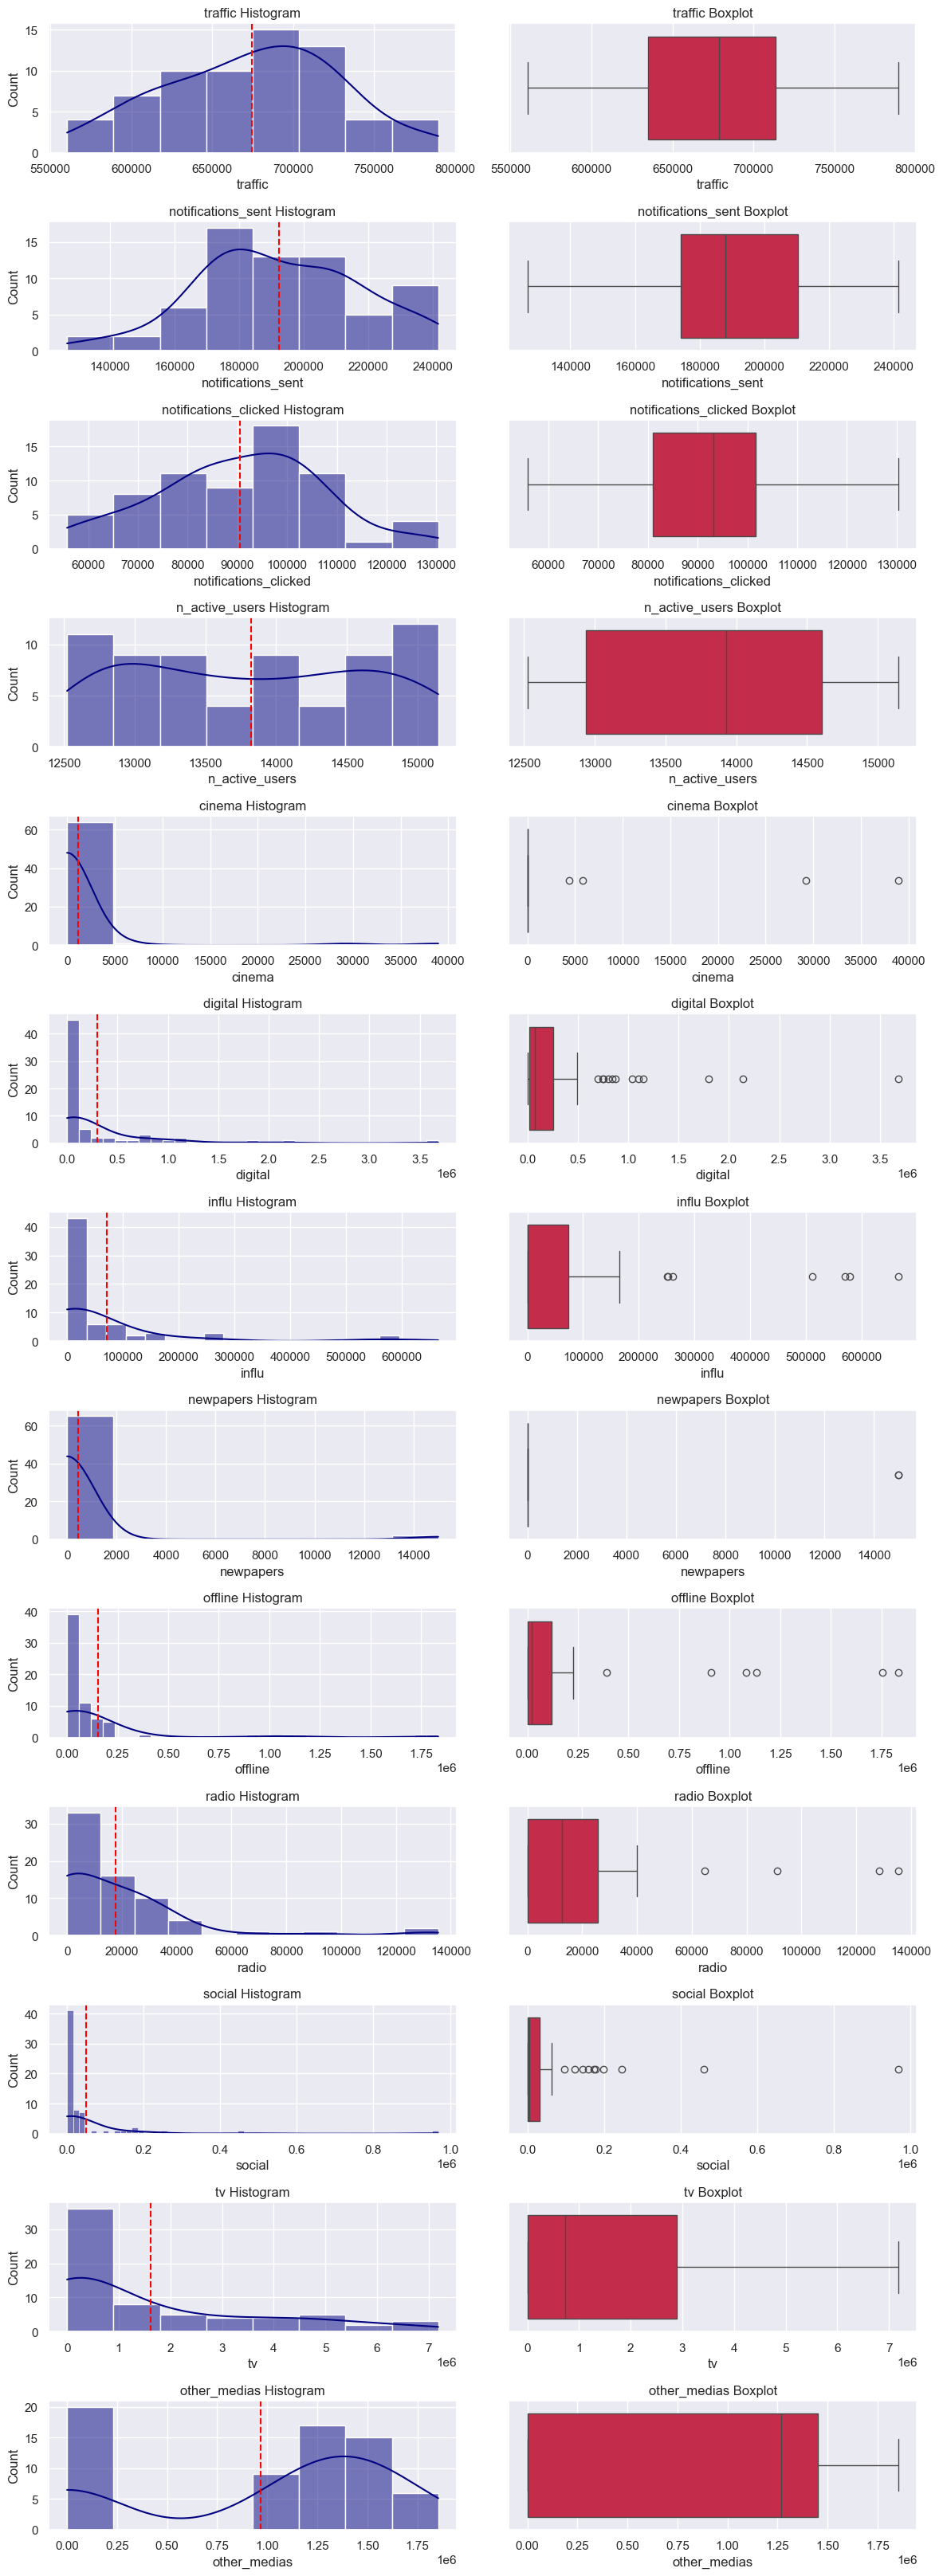

In [66]:
display(df_week[cols_describe].describe())
plot_histograms_features(df_week, cols_describe)

In [67]:
for i in ["traffic","notifications_sent","notifications_clicked"]:
    if is_normal(df_week[i], verbose=False):
        print(f"{i} is normal")
    else:
        print(f"{i} is not normal")

traffic is normal
notifications_sent is normal
notifications_clicked is normal


## Análise Temporal

Para entender qual a relação entre o investimento da mídia e o tráfego ao longo do tempo a visualização, o gráfico abaixo traz alguns insights interessantes, como:

1. Padrões de Investimento em Mídia:
 
- O investimento em mídia aumenta significativamente a partir de meados de jun/2007, com destaque para TV, que tem os maior volumes de investimentos, especialmente nos meses de set/2007 e a partir de mar/2008.
- "Other medias" (outras mídias) também tem um volume notável, constantemente distribuído a partir de jun/2007.
- Mídias como cinema, influenciadores, e offline têm um investimento menor e mais constante ao longo do período.
- Digital tem um alto investimento nos primeiros meses, quase deixando de aparecer a partir de out/2007. Uma hipótese é que pode não ter dado o retorno esperado, nas semanas conseguintes ao investimento.

2. Relação entre Investimento em Mídia e Tráfego no Site:
- O tráfego no site (linha azul) parece correlacionar-se positivamente, porém levemente com o investimento total em mídia (60%). Por exemplo, um aumento acentuado no investimento em set/2007 e março de 2008 está associado a picos de tráfego no site.
- A redução ou falta de investimento em mídias parece estar relacionada com os momentos futudos de queda no tráfego, mostrando que esses acontecimentos sofrem de efeitos de adstock. Um exemplo disso, é a redução de investimentos entre set e dez/2007 

3. Eficácia Variada das Mídias:

- Mídias como TV e "Other medias" parecem estar associadas a picos de tráfego, sugerindo que essas mídias podem ser mais eficazes para impulsionar visitas ao site.
- Em contrapartida, algumas mídias tem baixos investimentos e/ou são pontuais, como é o caso de rádio, newspapers e cinema, que têm menor investimento, podem estar contribuindo menos diretamente para o tráfego. Se o investimento for baixo demais, pode ser que não tenha gerado nenhum ou pouquíssimo impacto no tráfego.


4. Impacto dos Eventos no tráfego:
- Os eventos parecem estar positivamente correlacionados com o tráfego. Sem considerar lag, o evento 1 parece ser um bom investimento para trazer mais tráfego.

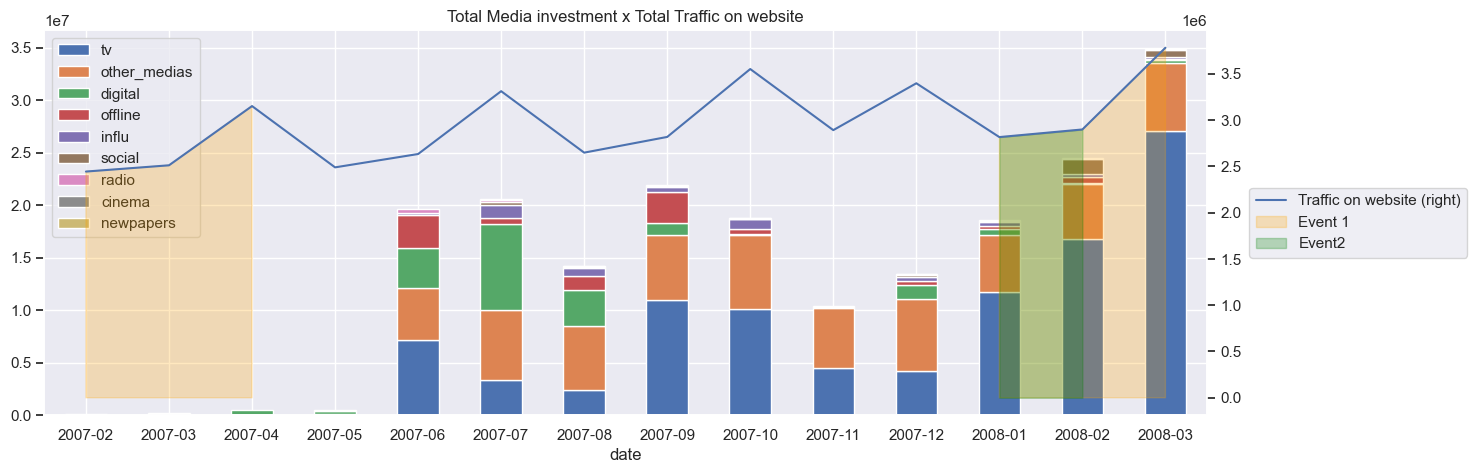

In [68]:
df_month_agg = df_week[df_week.date.between("2007-02-01", "2008-03-31")].resample("ME", on="date").agg(cols_agg)

df_month_agg.index = df_month_agg.index.strftime("%Y-%m")
plot_media_traffic(df_month_agg, medias, fig_size=(15,5))

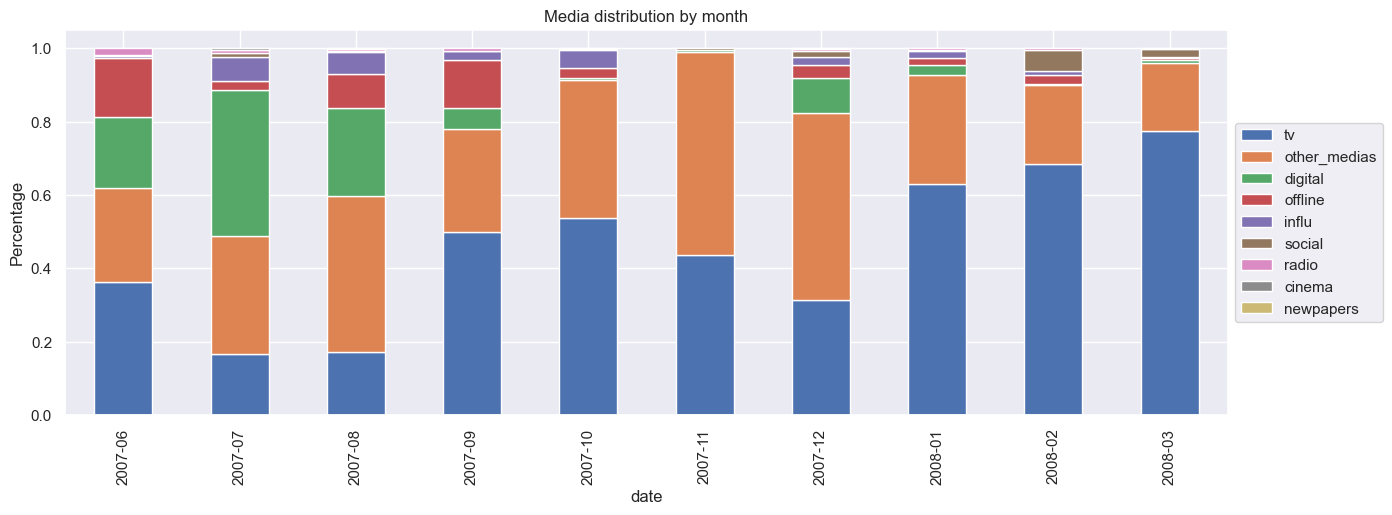

In [69]:
# após 2007-05-01

plot_stacked_media(df_month_agg[df_month_agg.index>"2007-05-01"], medias)

In [70]:
pd.concat([df_month_agg[medias].sum(axis = 1), df_month_agg["traffic"]], axis = 1).corr()

,0,traffic
0,1.0000,0.5976
traffic,0.5976,1.0000


# Key Performance Indicators (KPIs)

In [76]:
cumulative_growth = ((df_month_agg["n_active_users"].iloc[-1] - df_month_agg["n_active_users"].iloc[0])) / df_month_agg["n_active_users"].iloc[0]
annualized_growth = (1 + cumulative_growth) ** (12 / len(df_month_agg.index)) - 1
annualized_growth


0.15478586609243195

In [72]:
cumulative_growth = ((df_month_agg["traffic"].iloc[-1] - df_month_agg["traffic"].iloc[0])) / df_month_agg["traffic"].iloc[0]
annualized_growth = (1 + cumulative_growth) ** (12 / len(df_month_agg.index)) - 1
annualized_growth


0.4537967929527804

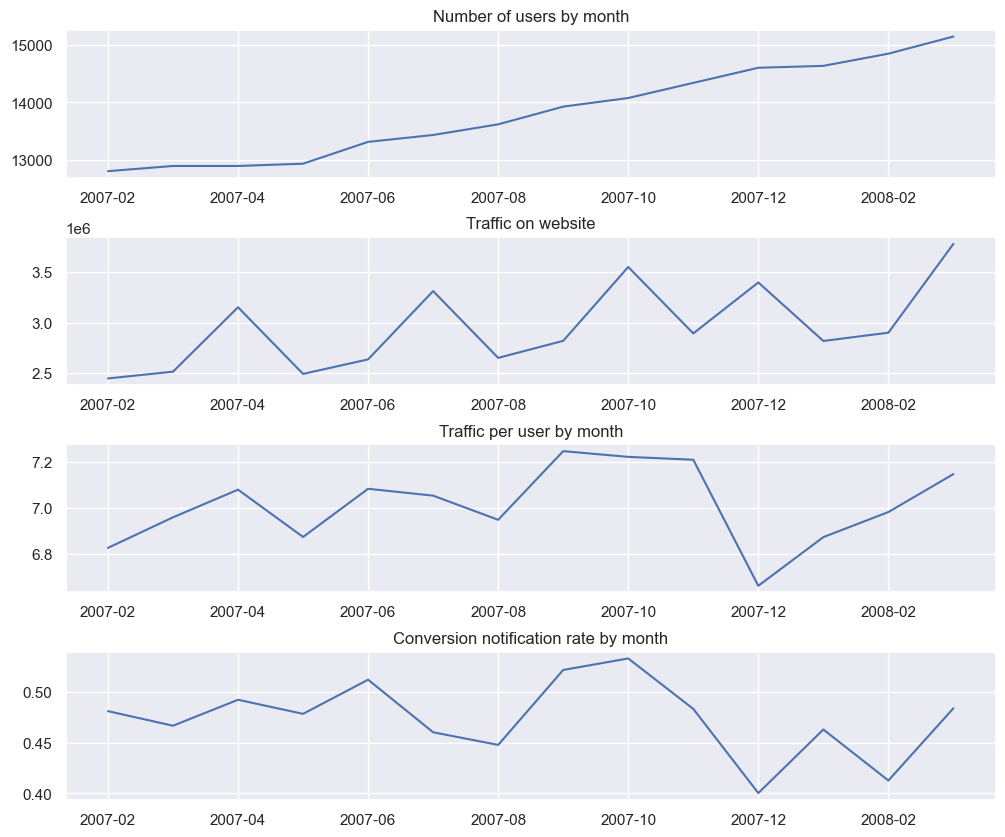

In [75]:
# dict = {column : plot title}
plot_dict = { 
    "n_active_users": "Number of users by month",
    "traffic": "Traffic on website",
    "traffic_per_user": "Traffic per user by month",
    "sent2click": "Conversion notification rate by month",
    # "total_media_investment": "Total media investment by month",
}

plot_kpis(df_month_agg, plot_dict)

### Correlação entre Variáveis

> Correlação entre Mídias
- Existem mídias que estão correlacionadas, como Cinema e Digital ou Rádio e Offline. Essa relação pode ser natural, pois muitos canais acabam levando a outros. Como já dito anteriormente, cinema e rádio tiveram baixíssimo investimento e junto a essa alta correlação, pode ser muito difícil capturarmos o efeito verdadeiro dessas duas mídias.
- Para conseguir ter um coeficiente explicativo "puro" para cada canal, é importante fazer algum tratamento, como ortogonalizar esses dados. 
- Número de usuários ativos têm altíssima correlação com o número de semanas e com o tráfego. Esse último parece fazer bastante sentido, dado que quanto mais usuários, maior o tráfego.
- Para realizar um modelo, podemos remover o weeks_from_start, pois o n_active_users já consegue trazer o efeito do "comportamento" orgânico de crescimento do tráfego.
- TV e outras mídias parecem trazer tráfego e mais usuários, mas pode ser que seja apenas que houve um aumento do investimento ao longo das semanas, por isso é importante que o número de usuários seja parte do modelo (como removedor de bias).

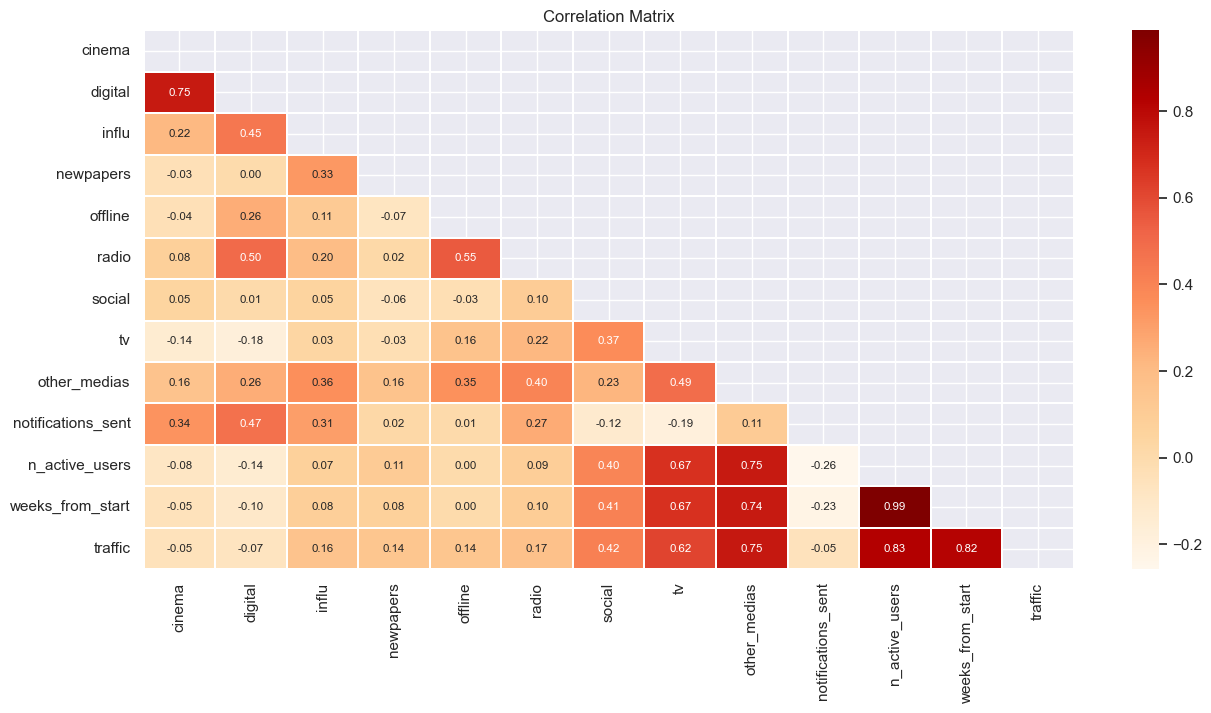

In [89]:
plot_corr_heatmap(df_week[medias + ["notifications_sent", "n_active_users", "weeks_from_start", "traffic", ]])

In [21]:
# Resumo
medias_with_more_investment = ["tv", "other_medias", "digital", "offline", "influ", "social"]
corr = df_week[medias_with_more_investment + ["notifications_sent", "n_active_users", "weeks_from_start", "traffic", ]].corr()
# remove triângulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))
corr = corr.where(mask)
corr = (corr[(corr > 0.5)&(corr < 1)].dropna(how="all", axis=1).dropna(how="all", axis=0)*100).round(1)
corr

,n_active_users,weeks_from_start,traffic
tv,67.3000,67.3000,61.6000
other_medias,74.6000,74.4000,75.0000
n_active_users,NaN,98.7000,82.7000
weeks_from_start,NaN,NaN,82.0000


# Adição de adstock para análises

In [126]:
medias_adstock = [f"{m}_adstock" for m in medias]

In [128]:
from src.utils.carryover_effect import decay_function, ExponentialCarryover
# prior knowledge
half_life_media = {
    "cinema": 3,
    "digital": 2,
    "influ": 1,
    "newpapers": 2,
    "offline": 4,
    "radio": 2,
    "social": 1,
    "tv": 3,
    "other_medias": 1,
}
lag_media = {
    "cinema": 1,
    "digital": 0,
    "influ": 0,
    "newpapers": 1,
    "offline": 2,
    "radio": 1,
    "social": 0,
    "tv": 1,
    "other_medias": 0,
}
# write decay function using half life for each media
decay_media = {m: decay_function(half_life) for m, half_life in half_life_media.items()}

for media in medias:
    carry = ExponentialCarryover(alpha = decay_media[media], L = lag_media[media]+1, func = "geo")
    df_week[f"{media}_adstock"] = carry.fit_transform(df_week[media])


Pela tabela e gráfico abaixo, o comportamento se mantém muito similar ao já comentado previamente. Pode ser que as priors não estejam bem calibradas, mas provavelmente, as correlações terão uma cara muito parecida.

In [129]:
# Resumo
corr = df_week[medias_adstock + ["notifications_sent", "n_active_users", "traffic", ]].corr()
# remove triângulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))
corr = corr.where(mask)
corr = (corr[(corr > 0.5)&(corr < 1)].dropna(how="all", axis=1).dropna(how="all", axis=0)*100).round(1)
corr

,digital_adstock,radio_adstock,other_medias_adstock,n_active_users,traffic
cinema_adstock,84.1000,NaN,NaN,NaN,NaN
digital_adstock,NaN,50.2000,NaN,NaN,NaN
offline_adstock,NaN,71.8000,NaN,NaN,NaN
tv_adstock,NaN,NaN,52.0000,75.4000,69.0000
other_medias_adstock,NaN,NaN,NaN,74.6000,75.0000
n_active_users,NaN,NaN,NaN,NaN,82.7000


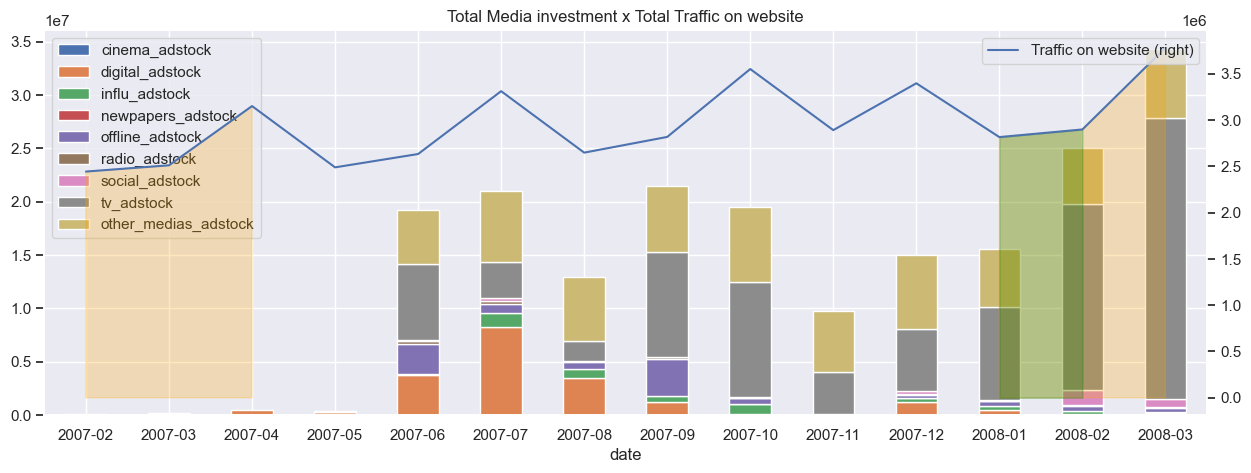

In [130]:
cols_adstock_agg = {
    'traffic': "sum",
    'notifications_sent': "sum",
    'notifications_clicked': "sum",
    'n_active_users': "max", # or mean
    'event1': "max",
    'event2': "max", 
    'cinema_adstock': "sum",
    'digital_adstock': "sum", 
    'influ_adstock': "sum", 
    'newpapers_adstock': "sum", 
    'offline_adstock': "sum",
    'radio_adstock': "sum",
    'social_adstock': "sum",
    'tv_adstock': "sum",
    'other_medias_adstock': "sum", 
    'holiday': "sum", # assumption: more holidays, more or less traffic than if 1 holiday
    'month': "max", 
    'week_of_month': "max",
}

df_month_agg = df_week[df_week.date.between("2007-02-01", "2008-03-31")].resample("ME", on="date").agg(cols_adstock_agg)

df_month_agg.index = df_month_agg.index.strftime("%Y-%m")
plot_media_traffic(df_month_agg, medias_adstock)